## ВШЭ, ФКН, ДПО, DS-6 (2021/2022), Курс "Deep Learning".
### ДЗ №2: Реализация градиентного спуска.
#### *Выполнил: Кирилл Н., 26.04.2022 г.*

__Задание:__ Необходимо реализовать линейный классификатор и натренировать его, используя различные модификации градиентного спуска. Тетрадка позаимствована с [шадовского курса по нейронкам.](https://github.com/yandexdataschool/Practical_DL/blob/master/week01_backprop/adapdive_sgd/adaptive_sgd.ipynb)

__NB:__ Выводы приведены внизу страницы синим цветом.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os

# Создаем папку для картинок png и gif
pic_folder_path = './hw2_pic'
os.makedirs(pic_folder_path, exist_ok=True)

### Генерация выборки

Для наших целей будем использовать искуственно сгенерированные данные.

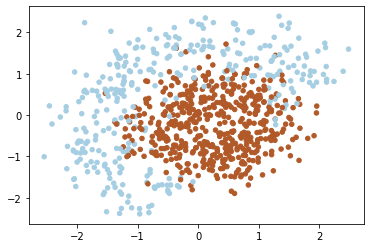

In [4]:
from sklearn import datasets, preprocessing

# keep random_state=42 for deterministic results
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4, random_state=42)
ind = np.logical_or(y == 1, X[:, 1] > X[:, 0] - 0.5)
X = X[ind, :]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

### [1] Варка фичей

Как вы можете заметить, данные не являются линейно разделимыми. Нам придётся добавить в обучающую выборку новые фичи либо использовать нелинейные модели. Предположим, что разделяющая поверхность имеет вид окружности. Добавьте в матрицу признаков дополнительные колонки $x_1^2$, $x_2^2$ и $x_1 \cdot x_2$.

In [5]:
def expand(X):
    """
    Добавляет квадратичные фичи. 
    Для каждой строки матрицы находит строку 
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]
    
    :param X: матрица фичей, shape [n_samples,2]
    :returns: расширенная матрица фичей, shape [n_samples,6]
    """
    if isinstance(X, list):
        X = np.array(X)
    
    if not isinstance(X, np.ndarray):
        return 0
    
    try:
        if X.shape[1] != 2:
            return 0
    except:
        return 0
    
    # ваш код здесь
    X_col23 = X**2 #2-й и 3-й столбцы расширенной матрицы (feature0^2 и feature1^2)
    X_col4 = X[:,0] * X[:,1] # 4-й столбец расширенной матрицы (feature0*feature1)
    X_col5 = np.ones(X.shape[0]) # 5-й столбец расширенной матрицы (единицы)
    
    X_exp = np.c_[X, X_col23, X_col4, X_col5]
    
    return X_exp

In [6]:
# Testing of expand(X)

assert expand([]) == 0
assert expand([[], []]) == 0
assert np.allclose(expand(np.array([[1, 3]])), np.array([[1, 3, 1, 9, 3, 1]]))
assert np.allclose(expand(np.array([[1, 2], [3, 4]])), np.array([[1, 2, 1, 4, 2, 1], [3, 4, 9, 16, 12, 1]]))

print("Testing of expand(X) - OK")

Testing of expand(X) - OK


In [7]:
# Expanding X
X = expand(X)

### [3] Логистическая регрессия 

Для классификации будем использовать логистическую регрессию. 

$$ a(x, w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$


In [8]:
def probability(X, w):
    """
    Принимает на вход матрицу фичей и вектор весов
    Возвращает предсказание вероятность того, что y = 1 при фиксированных x, P(y=1|x)
    
    :param X: расширенная матрица фичей [n_samples,6] (expanded)
    :param w: вектор весов [6]
    :returns: вектор вероятностей
    """

    # ваш код здесь
    probs = 1 / (1 + np.exp(-np.dot(w,X.T)))
    return probs

In [9]:
# Testing of probability(X, w)

dummy_X = np.array([
        [0,0],
        [1,0],
        [2.61,-1.28],
        [-0.59,2.1]
    ])
dummy_w = np.linspace(-1,1,6)
dummy_probs = probability(expand(dummy_X), dummy_w)
dummy_answers = np.array([ 0.73105858,  0.450166  ,  0.02020883,  0.59844257])

assert isinstance(dummy_probs, np.ndarray), "please return np.array"
assert dummy_probs.shape == dummy_answers.shape, "please return an 1-d vector with answers for each object"
assert np.allclose(dummy_probs, dummy_answers,1e-3), "There's something non-canonic about how probabilties are computed"

print("Testing of probability(X, w) - OK")

Testing of probability(X, w) - OK


Для логистической регрессии оптимальный параметр находится минимизацией кросс-энтропии: 

$$ L(w) =  - {1 \over \ell} \sum_{i=1}^\ell \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1 \, | \, x_i,w))}\right] =
- {1 \over \ell} \sum_{i=1}^\ell \left[ {y_i \cdot log(\sigma(\langle w, x \rangle)) + (1-y_i) \cdot log(\sigma(-\langle w, x \rangle))}\right] $$



In [10]:
def compute_loss(X, y, w):
    """
    Принимает на вход матрицу фичей, вектор ответов и вектор весов.
    Выдаёт на выход значение функции потерь, рассчитанное по формуле выше.
    """

    # ваш код здесь
    loss = -np.sum( 
        y*np.log(probability(X, w)) + 
        (np.ones(y.shape[0])-y)*np.log(probability(X, -w))
    ) / y.shape[0] 
    
    return loss

In [11]:
# Testing of compute_loss(X, y, w)

# Test 1
from sklearn.metrics import log_loss

dummy_w = np.array([1, -2, 0, 4, -5, 6])
dummy_X = expand(np.array([[1, 2], [3, 4]]))
dummy_y = np.array([1, 0])

dummy_probs = probability(dummy_X, dummy_w)
assert np.allclose(log_loss(dummy_y, dummy_probs), compute_loss(dummy_X, dummy_y, dummy_w), 1e-3)

# Test 2
dummy_X = np.array([
        [0,0],
        [1,0],
        [2.61,-1.28],
        [-0.59,2.1]
    ])
dummy_weights = np.linspace(-1,1,6)
dummy_y = np.array([0,1,0,1])

dummy_loss = compute_loss(expand(dummy_X),dummy_y,dummy_weights)
assert np.allclose(dummy_loss,0.66131), "something wrong with loss"

print("Testing of compute_loss(X, y, w) - OK")

Testing of compute_loss(X, y, w) - OK


Мы будем обучать модель методом градиентного спуска. Для этого нам придётся вычислить градиент функции потерь, представленной выше. Возьмите листочек, ручку и в бой! 

$$ \nabla_w L = - {1 \over \ell} \sum_{i=1}^\ell \left[ {x_i \cdot (y_i - \sigma(\langle w, x_i \rangle))}\right] $$

Тут обойдёмся даже без матричного дифириенцирования. А вот в следущий раз его не миновать...

In [12]:
def compute_grad(X, y, w):
    """
    Нахоит значение градиента.
    """

    # ваш код здесь
    mult = (X.T*(y - probability(X, w)).T).T
    grad = -np.sum(mult, axis=0) / y.shape[0] 
                   
    return grad

In [13]:
# Testing of compute_grad(X, y, w) 

dummy_matr = np.array([[1, 2], 
              [3, 4],
             [-2, -4]])
dummy_vect = np.array([2, 4, 3])
dummy_answers = np.array([8, 8])

# Умножаем каждую строку матрицы на соответствующую компоненту вектора, получаем матрицу того же размера
mult_per_obj = (dummy_matr.T*dummy_vect.T).T
print("Произведение строк матрицы на соответствующие элементы вектора:")
print(mult_per_obj)

# Складываем элементы полученной матрицы по столбцам, получаем суммарный вектор признаков
sum_per_obj = np.sum(mult_per_obj, axis=0)
print("\nСумма строк матрицы-произведения:")
print(sum_per_obj)

assert np.allclose(sum_per_obj, dummy_answers, 1e-3), "something wrong with loss"

print("\nTesting of compute_grad(X, y, w) - OK")

Произведение строк матрицы на соответствующие элементы вектора:
[[  2   4]
 [ 12  16]
 [ -6 -12]]

Сумма строк матрицы-произведения:
[8 8]

Testing of compute_grad(X, y, w) - OK


Функция ниже предназначена для визуализации процесса обучения. 

In [14]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    
    fig = plt.figure(figsize=(12, 5))
    
    """С помощью магии matplolib выдаёт красоты результатов классификации"""
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    
    #plt.show()
    #plt.close()
    return fig

In [15]:
# Созадем gif-файл из нескольких png-картинок

from PIL import Image

def to_gif(png_list, gif_name):
    
    frames = []
    for i in png_list:
        new_frame = Image.open(i)
        frames.append(new_frame)

    frames[0].save(gif_name, format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=1000, loop=0)

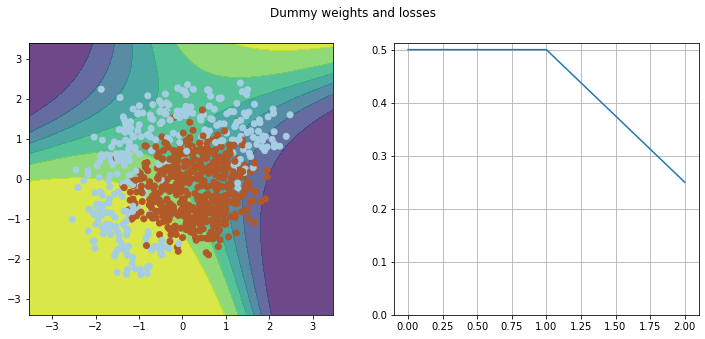

In [16]:
# Убедитесь, что у вас она работает, запустив код ниже 
# (он отработает если вы верно реализовали expand и probability)

dummy_weights = np.linspace(-1, 1, 6)
fig = visualize(X, y, dummy_weights, [0.5, 0.5, 0.25])
fig.suptitle("Dummy weights and losses")
fig.show()

## Обучение

Пришло время обучить нашу модель. Для этого вам придётся дописать кусочки функций ниже. Обязательно попробуйте поменять гиперпараметры (размер батча и скорость обучения) и посмотреть как будет изменяться анимация. 

### [2] Mini-batch SGD

Берём несколько рандомных наблюдений и ищем градиент по ним! 

$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$



In [17]:
# Создаем png-картинку для заданных значений batch_size и eta

np.random.seed(42)

def minibatch_sgd(batch_size, eta, png_name):  
    
    w = np.array([0, 0, 0, 0, 0, 1])
    #eta = 0.1 
    n_iter = 100
    loss = np.zeros(n_iter)

    for i in range(n_iter):
    
        # Ваш код здесь
        idx = np.random.choice(y.shape[0], batch_size, replace=False)
        w = w - eta * compute_grad(X[idx, :], y[idx], w)
        loss[i] = compute_loss(X, y, w)
    
    fig = visualize(X, y, w, loss)
    fig.suptitle(f"batch_size={batch_size}, eta={eta}, loss={loss[n_iter-1]:.4f}")
    fig.savefig(png_name)
    plt.clf()

In [18]:
# Создаем gif-картинку для различных значений batch_size и eta

png_list = []

eta = 0.1
for batch_size in [200, 100, 50, 10, 4]:
    png_name = f"{pic_folder_path}/minibatch_bsize={batch_size}_eta={eta}.png"
    png_list.append(png_name)
    minibatch_sgd(batch_size, eta, png_name)

batch_size = 4
for eta in [1., 0.1, 0.01, 0.001]:
    png_name = f"{pic_folder_path}/minibatch_bsize={batch_size}_eta={eta}.png"
    png_list.append(png_name)
    minibatch_sgd(batch_size, eta, png_name)

        
gif_name = 'minibatch_sgd.gif'
to_gif(png_list, f"{pic_folder_path}/{gif_name}")

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

**Mini-batch SGD**
<img src="hw2_pic/minibatch_sgd.gif" width="800">

### [2] Momentum SGD

Momentum это метод, который помогает стохастическому градиентному спуску сохранять направление движения. Это осуществляется за счёт добавления в выражение дополнительного слагаемого, накопленного за предыдущие шаги градиента с весом $\alpha$. 
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$
$$ w_t = w_{t-1} - \nu_t$$


In [19]:
# Создаем png-картинку для заданных значений batch_size и eta

np.random.seed(42)

def momentum_sgd(batch_size, eta, png_name):
    
    w = np.array([0, 0, 0, 0, 0, 1])
    alpha = 0.9 
    nu = np.zeros_like(w)
    n_iter = 100
    loss = np.zeros(n_iter)

    for i in range(n_iter):
    
        # Ваш код здесь 
        idx = np.random.choice(y.shape[0], batch_size, replace=False)
        nu = alpha*nu + eta*compute_grad(X[idx], y[idx], w)
        w = w - nu
        loss[i] = compute_loss(X, y, w)

    fig = visualize(X, y, w, loss)
    fig.suptitle(f"batch_size={batch_size}, eta={eta}, loss={loss[n_iter-1]:.4f}")
    fig.savefig(png_name)
    plt.clf()

In [20]:
# Создаем gif-картинку для различных значений batch_size и eta

png_list = []

eta = 0.05
for batch_size in [200, 100, 50, 10, 4]:
    png_name = f"{pic_folder_path}/momentum_bsize={batch_size}_eta={eta}.png"
    png_list.append(png_name)
    momentum_sgd(batch_size, eta, png_name)

batch_size = 4
for eta in [1., 0.1, 0.05, 0.001]:
    png_name = f"{pic_folder_path}/momentum_bsize={batch_size}_eta={eta}.png"
    png_list.append(png_name)
    momentum_sgd(batch_size, eta, png_name)

gif_name = 'momentum_sgd.gif'
to_gif(png_list, f"{pic_folder_path}/{gif_name}")

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

**Momentum SGD**
<img src="hw2_pic/momentum_sgd.gif" width="800">

### [2] RMSprop

В этом блоке реализуем RMSprop. Эта вариация градиентного спуска позволяет изменять скорость обучения индивидуально для каждого параметра. 

$$ G_t^j = \alpha G_{t-1}^j + (1 - \alpha) g_{tj}^2 $$
$$ w_t^j = w_{t-1}^j - \dfrac{\eta}{\sqrt{G_t^j + \varepsilon}} g_{tj} $$

In [21]:
# Создаем png-картинку для заданных значений batch_size и eta

np.random.seed(42)

def rmsprop_sgd(batch_size, eta, png_name):

    w = np.array([0, 0, 0, 0, 0, 1.])
    #eta = 0.1 
    alpha = 0.9 
    G = np.zeros_like(w)
    eps = 1e-8
    eps_vect = np.array([eps]*X.shape[1])
    n_iter = 100
    loss = np.zeros(n_iter)

    for i in range(n_iter):

        # Ваш код здесь 
        idx = np.random.choice(y.shape[0], batch_size, replace=False)
        grad = compute_grad(X[idx], y[idx], w)
        G = alpha*G + (1-alpha)*grad**2
        w = w - eta*grad/np.sqrt(G+eps_vect)
        loss[i] = compute_loss(X, y, w)
    
    fig = visualize(X, y, w, loss)
    fig.suptitle(f"batch_size={batch_size}, eta={eta}, loss={loss[n_iter-1]:.4f}")
    fig.savefig(png_name)
    plt.clf() 

In [22]:
# Создаем gif-картинку для различных значений batch_size и eta

png_list = []

eta = 0.1
for batch_size in [200, 100, 50, 10, 4]:
    png_name = f"{pic_folder_path}/rmsprop_bsize={batch_size}_eta={eta}.png"
    png_list.append(png_name)
    rmsprop_sgd(batch_size, eta, png_name)

batch_size = 4
for eta in [1., 0.1, 0.01, 0.001]:
    png_name = f"{pic_folder_path}/rmsprop_bsize={batch_size}_eta={eta}.png"
    png_list.append(png_name)
    rmsprop_sgd(batch_size, eta, png_name)

gif_name = 'rmsprop_sgd.gif'
to_gif(png_list, f"{pic_folder_path}/{gif_name}")

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

**RMSprop SGD**
<img src="hw2_pic/rmsprop_sgd.gif" width="800">

Как траектории обучения различных вариаций градиентного спуска различаются между собой? Ожидаемо ли это? Почему? Что нужно сделать, чтобы реализовать Adam? 
(см. выводы внизу синим цветом) 

### [2] За каждую адекватную вариацию

Если понравилось реализовывать свои градиентные спуски и ты находишься от них под глубоким впечатлением, предлагается реализовать Adam за дополнительные баллы. 

**a) Adam (Adaptive Moment Estimation)**


$$ h_t^j = \beta_1 h_{t-1}^j + (1 - \beta_1) g_{tj} $$
$$ G_t^j = \beta_2 G_{t-1}^j + (1 - \beta_2) g_{tj}^2 $$
$$ w_t^j = w_{t-1}^j - \dfrac{\eta}{\sqrt{G_t^j + \varepsilon}} h_t^j $$

In [23]:
# Создаем png-картинку для заданных значений batch_size и eta

np.random.seed(42)

def adam_sgd(batch_size, eta, png_name):
    
    w = np.array([0, 0, 0, 0, 0, 1.])
    #eta = 0.1 
    beta1 = 0.9
    beta2 = 0.999
    G = np.zeros_like(w)
    h = np.zeros_like(w)
    eps = 1e-8
    eps_vect = np.array([eps]*X.shape[1])
    n_iter = 100
    loss = np.zeros(n_iter)

    for i in range(n_iter):

        # Ваш код здесь 
        idx = np.random.choice(y.shape[0], batch_size, replace=False)
        grad = compute_grad(X[idx], y[idx], w)
        h = beta1*h + (1-beta1)*grad
        G = beta2*G + (1-beta2)*grad**2
        w = w - eta*h/np.sqrt(G+eps_vect)
        loss[i] = compute_loss(X, y, w)

    fig = visualize(X, y, w, loss)
    fig.suptitle(f"batch_size={batch_size}, eta={eta}, loss={loss[n_iter-1]:.4f}")
    fig.savefig(png_name)
    plt.clf()

In [24]:
# Создаем gif-картинку для различных значений batch_size и eta

png_list = []

eta = 0.1
for batch_size in [200, 100, 50, 10, 4]:
    png_name = f"{pic_folder_path}/adam_bsize={batch_size}_eta={eta}.png"
    png_list.append(png_name)
    adam_sgd(batch_size, eta, png_name)

batch_size = 4
for eta in [1., 0.1, 0.01, 0.001]:
    png_name = f"{pic_folder_path}/adam_bsize={batch_size}_eta={eta}.png"
    png_list.append(png_name)
    adam_sgd(batch_size, eta, png_name)

gif_name = 'adam_sgd.gif'
to_gif(png_list, f"{pic_folder_path}/{gif_name}")

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

**Adam SGD**
<img src="hw2_pic/adam_sgd.gif" width="800">

**b) Adam with bias correction**


$$ h_t^j = \beta_1 h_{t-1}^j + (1 - \beta_1) g_{tj} $$
$$ G_t^j = \beta_2 G_{t-1}^j + (1 - \beta_2) g_{tj}^2 $$
$$ \hat{h_t^j} = \dfrac{h_t^j}{1-\beta_1^t}, \hat{G_t^j} = \dfrac{G_t^j}{1-\beta_2^t}$$
$$ w_t^j = w_{t-1}^j - \dfrac{\eta}{\sqrt{\hat{G_t^j} + \varepsilon}} \hat{h_t^j} $$

In [25]:
# Создаем png-картинку для заданных batch_size и eta

np.random.seed(42)

def adam_corr_sgd(batch_size, eta, png_name):

    w = np.array([0, 0, 0, 0, 0, 1.])
    #eta = 0.1 
    beta1 = 0.9
    beta2 = 0.999
    G = np.zeros_like(w)
    h = np.zeros_like(w)
    eps = 1e-8
    eps_vect = np.array([eps]*X.shape[1])
    n_iter = 100
    loss = np.zeros(n_iter)

    for i in range(n_iter):

        # Ваш код здесь 
        idx = np.random.choice(y.shape[0], batch_size, replace=False)
        grad = compute_grad(X[idx], y[idx], w)
        h = beta1*h + (1-beta1)*grad
        G = beta2*G + (1-beta2)*grad**2
    
        # Отдельно обрабатываем случай, когда i==0
        if i==0:
            h_hat = h
            G_hat = G
        else:
            h_hat = h/(1-beta1**i)
            G_hat = G/(1-beta2**i)

        w = w - eta*h_hat/np.sqrt(G_hat+eps_vect)
        loss[i] = compute_loss(X, y, w)
    
    fig = visualize(X, y, w, loss)
    fig.suptitle(f"batch_size={batch_size}, eta={eta}, loss={loss[n_iter-1]:.4f}")
    fig.savefig(png_name)
    plt.clf()

In [26]:
# Создаем gif-картинку для различных значений batch_size и eta

png_list = []

eta = 0.1
for batch_size in [200, 100, 50, 10, 4]:
    png_name = f"{pic_folder_path}/adam_corr_bsize={batch_size}_eta={eta}.png"
    png_list.append(png_name)
    adam_corr_sgd(batch_size, eta, png_name)

batch_size = 4
for eta in [1., 0.1, 0.01, 0.001]:
    png_name = f"{pic_folder_path}/adam_corr_bsize={batch_size}_eta={eta}.png"
    png_list.append(png_name)
    adam_corr_sgd(batch_size, eta, png_name)

gif_name = 'adam_corr_sgd.gif'
to_gif(png_list, f"{pic_folder_path}/{gif_name}")

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

**Adam with bias correction SGD**
<img src="hw2_pic/adam_corr_sgd.gif" width="800">

<span style="color:blue">
Выводы: 
    
- Как видно из рисунков, параметр batch size в большей степени влияет не на размер ошибки, а на вычислительную сложность и 
соответственно длительность поиска минимума. Т.е. чем больше batch size, тем меньше 
отклонений от направления градиента совершает вектор весов и тем плавнее выглядит кривая ошибки. 
Однако при этом выполняется больше вычислений.
- У параметра скорости обучения $\eta$ нет такой монотонной связи с ошибкой. 
При больших значениях $\eta$ погрешность может быть ниже, однако есть риск пропустить точку минимума. 
С другой стороны, при малых значениях $\eta$ ошибка снижается слишком медленно. 
Поэтому, как видно из приведенных картинок, оптимальными в данном случае являются значения $\eta$ = 0.05-0.1.
- Адаптивные методы дают меньшую ошибку и соответственно строят более оптимальную разделяющую плоскость 
благодаря индивидуальной настройке скорости обучения по каждому направлению, а также использованию нескольких
значений градиента путем вычисления скользящих средних (Adam и Adam with bias correction). 
Из всех реализованных выше методов самая низкая ошибка на последней итерации при прочих равных параметрах 
получилась у Adam with bias correction, т.к. он комбинирует в себе остальные подходы.

</span>

In [ ]:
# Удаляем папку с картинками

import shutil

answer = input("Вы уверены, что хотите удалить все картинки? (Y/N)")
if answer.strip().lower()[0] == 'y':
    try:
        shutil.rmtree(pic_folder_path)
        print(f"{pic_folder_path} is removed")
    except:
        print("Already removed")
        
else:
    print("Папка с картинками сохранена")